In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from pprint import pprint
titers = pd.read_csv('../data/katzelnick2015/processed/dengue_titers.tsv', 
                     sep='\t', names=['virus', 'sera', 'individual', 'sera-source', 'titer'], header=0)
print titers.head()

                        virus                                    sera  \
0  DENV1/BOLIVIA/FSB3363/2010  DENV1/NAURU/WESTERNPACIFICDELTA30/1974   
1  DENV1/BOLIVIA/FSB3363/2010  DENV1/NAURU/WESTERNPACIFICDELTA30/1974   
2  DENV1/BOLIVIA/FSB3363/2010  DENV1/NAURU/WESTERNPACIFICDELTA30/1974   
3  DENV1/BOLIVIA/FSB3363/2010  DENV1/NAURU/WESTERNPACIFICDELTA30/1974   
4  DENV1/BOLIVIA/FSB3363/2010  DENV1/NAURU/WESTERNPACIFICDELTA30/1974   

   individual sera-source  titer  
0           3  monovalent     20  
1          13  monovalent     17  
2          15  monovalent     12  
3          19  monovalent     10  
4          38  monovalent     13  


In [2]:
def autologous_norm(df, drop=True):
    '''
    Returns original df with added column of autologous-norm titer values. 
    If drop=True (default), will drop rows without a valid autologous values.
    '''
    autologous_vals = df[['sera', 'sera-source', 'individual']]
    autologous_vals.drop_duplicates(inplace=True)
    
    def find_autologous(row):
        '''
        For each unique combination of sera + dataset + individual, return the autologous log2 titer value
        '''
        a = df.loc[(df['virus'] == row['sera']) &       # Find where each sera was titered against itself...
                   (df['sera'] == row['sera']) &
                   (df['sera-source'] == row['sera-source']) & #...in the same dataset
                   (df['individual'] == row['individual'])]['log2titer'] #...from the same individual
        assert len(a) <= 1 # Should be exactly 1 autologous value
        if len(a.values) > 0:
            return a.values[0]
        else:
            return np.nan
    
    def normalize_values(row):
        '''
        For each row of the original dataframe, pull the autologous log2 titer value and 
        return the normalized log2 titer value
        '''
        a = autologous_vals.loc[(autologous_vals['sera'] == row['sera']) &
                                (autologous_vals['sera-source'] == row['sera-source']) & #...in the same dataset
                                (autologous_vals['individual'] == row['individual'])]['autologous_log2titer'] #...from the same individual
        assert len(a) == 1
        
        if not np.isnan(a.values[0]):
            return  a.values[0] - row['log2titer']
        else:
            return np.nan
        
    ## Formulated as nested functions to take advantage of the efficient pandas .apply function mapping
    autologous_vals.loc[:,'autologous_log2titer'] = autologous_vals.apply(find_autologous, axis=1)
    df.loc[:,'autologous_log2titer'] = df.apply(normalize_values, axis=1)
    
    if drop:
        df.dropna(axis=0, how='any', subset=['autologous_log2titer'], inplace=True)
    return df

In [3]:
titers['log2titer'] = np.log2(titers['titer']) # Put titers on a log2 scale
titers = autologous_norm(titers) # Normalize log2 titers
titers['virussera'] = titers['virus']+'_'+titers['sera'] # Add a concatenated identifier
titers['species'] = ['agm' if 'agm' in i else 'human' for i in titers['sera-source']] # Recode to combine agm timepoints
print titers.head()

/Library/Python/2.7/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)
/Library/Python/2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


                        virus                                    sera  \
0  DENV1/BOLIVIA/FSB3363/2010  DENV1/NAURU/WESTERNPACIFICDELTA30/1974   
2  DENV1/BOLIVIA/FSB3363/2010  DENV1/NAURU/WESTERNPACIFICDELTA30/1974   
3  DENV1/BOLIVIA/FSB3363/2010  DENV1/NAURU/WESTERNPACIFICDELTA30/1974   
4  DENV1/BOLIVIA/FSB3363/2010  DENV1/NAURU/WESTERNPACIFICDELTA30/1974   
5  DENV1/BOLIVIA/FSB3363/2010                DENV2/TONGA/DELTA30/1974   

   individual sera-source  titer  log2titer  autologous_log2titer  \
0           3  monovalent     20   4.321928             -0.074001   
2          15  monovalent     12   3.584963              0.115477   
3          19  monovalent     10   3.321928              0.485427   
4          38  monovalent     13   3.700440              0.299560   
5          13  monovalent     43   5.426265              2.788054   

                                           virussera species  
0  DENV1/BOLIVIA/FSB3363/2010_DENV1/NAURU/WESTERN...   human  
2  DENV1/BOLIVIA/FSB

/Library/Python/2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [4]:
### Several ways to wrangle the data. 
### Option 1: combine all the agm data, compare in aggregate to human data.

human_titers = titers.loc[titers['species'] == 'human'] # measurements done in humans
agm_titers = titers.loc[titers['species'] == 'agm'] # measurements done in monkeys
agg_agm_human_titers = human_titers.merge(agm_titers, how='inner', on=['virussera']) # measurements done in both

agg_agm_human_titers = titers.loc[titers.virussera.isin(agg_agm_human_titers.virussera.values)] # map back to original data

agg_agm_human_titers = agg_agm_human_titers[['virussera', 'species', 'autologous_log2titer']] # drop unnecessary columns
agg_agm_human_titers['species'] = agg_agm_human_titers['species'].astype('category') # recode as categorical variable
print agg_agm_human_titers.head()

                                            virussera species  \
90  DENV1/THAILAND/16007/1964_DENV2/TONGA/DELTA30/...   human   
91  DENV1/THAILAND/16007/1964_DENV2/TONGA/DELTA30/...   human   
92  DENV1/THAILAND/16007/1964_DENV2/TONGA/DELTA30/...   human   
93  DENV1/THAILAND/16007/1964_DENV2/TONGA/DELTA30/...   human   
94  DENV1/THAILAND/16007/1964_DENV2/TONGA/DELTA30/...   human   

    autologous_log2titer  
90              2.415037  
91              1.253757  
92              1.347923  
93              2.035624  
94              3.000000  


In [5]:
### Option 2: Keep the agm timepoints separate, compare to each other.

agm_titers = titers.loc[titers['species'] == 'agm'] # measurements done in monkeys
agm_titers = agm_titers[['virussera', 'sera-source', 'autologous_log2titer']] # drop unnecessary columns
agm_titers['sera-source'] = agm_titers['sera-source'].astype('category') # code as categorical data

print agm_titers.head()

                                             virussera sera-source  \
728  DENV1/BOLIVIA/FSB3363/2010_DENV1/VIETNAM/BIDV1...     agm_1mo   
729  DENV1/BOLIVIA/FSB3363/2010_DENV1/PUERTO_RICO/B...     agm_1mo   
731  DENV1/BOLIVIA/FSB3363/2010_DENV1/CAMBODIA/BIDV...     agm_1mo   
732  DENV1/BOLIVIA/FSB3363/2010_DENV1/MYANMAR/61117...     agm_1mo   
733  DENV1/MYANMAR/61117/2005_DENV1/VIETNAM/BIDV193...     agm_1mo   

     autologous_log2titer  
728              1.756729  
729              0.425306  
731              0.758992  
732              2.859039  
733             -0.679911  


In [6]:
### Option 3: Compare separate agm timepoints to human data

all_titers = titers[['virussera', 'sera-source', 'autologous_log2titer']] # drop unnecessary columns
all_titers['sera-source'] = all_titers['sera-source'].astype('category') # code as categorical data

print all_titers.head()

                                           virussera sera-source  \
0  DENV1/BOLIVIA/FSB3363/2010_DENV1/NAURU/WESTERN...  monovalent   
2  DENV1/BOLIVIA/FSB3363/2010_DENV1/NAURU/WESTERN...  monovalent   
3  DENV1/BOLIVIA/FSB3363/2010_DENV1/NAURU/WESTERN...  monovalent   
4  DENV1/BOLIVIA/FSB3363/2010_DENV1/NAURU/WESTERN...  monovalent   
5  DENV1/BOLIVIA/FSB3363/2010_DENV2/TONGA/DELTA30...  monovalent   

   autologous_log2titer  
0             -0.074001  
2              0.115477  
3              0.485427  
4              0.299560  
5              2.788054  


/Library/Python/2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
def get_comparable(df, datasets):
    sub_datasets = {}
    for dataset in datasets:
        sub_datasets[dataset] = df.loc[df['sera-source'] == dataset]
    
    all_agm = set.union(*[
                set(sub_datasets['agm_1mo'].virussera.values),
                set(sub_datasets['agm_3mo'].virussera.values),
                set(sub_datasets['agm_5mo'].virussera.values)
                ])
    human_plus_any_agm = set.intersection(*[
                        set(sub_datasets['monovalent'].virussera.values),
                        all_agm 
                        ])
    
#     comparable_virussera = set.intersection(*[set(dataset.virussera.values) for dataset in sub_datasets.values()])
#     comparable_values = df.loc[df.virussera.isin(comparable_virussera)]

    comparable_values = df.loc[df.virussera.isin(human_plus_any_agm)]
    return comparable_values

all_comparable_titers = get_comparable(all_titers, ['monovalent', 'agm_1mo', 'agm_3mo', 'agm_5mo'])
print pd.value_counts(all_comparable_titers['sera-source'])
print pd.value_counts(all_comparable_titers['virussera'])

monovalent    130
agm_1mo        12
agm_3mo        11
agm_5mo         7
Name: sera-source, dtype: int64
DENV2/VIETNAM/AC21/2003_DENV2/TONGA/DELTA30/1974                 13
DENV2/TONGA/DELTA30/1974_DENV2/TONGA/DELTA30/1974                13
DENV2/MALAYSIA/DKD811/2008_DENV2/TONGA/DELTA30/1974              12
DENV2/VIETNAM/AC20/2003_DENV2/TONGA/DELTA30/1974                 12
DENV2/PAPUANEWGUINEA/NEWGUINEAC/1944_DENV2/TONGA/DELTA30/1974    12
DENV2/VIETNAM/BIDV735/2006_DENV2/TONGA/DELTA30/1974              11
DENV1/THAILAND/16007/1964_DENV2/TONGA/DELTA30/1974               11
DENV2/PERU/IQT2913/1996_DENV2/TONGA/DELTA30/1974                 11
DENV2/NICARAGUA/BIDV571/2006_DENV2/TONGA/DELTA30/1974            11
DENV3/VIETNAM/BIDV1329/2006_DENV2/TONGA/DELTA30/1974             10
DENV2/NICARAGUA/BIDV533/2005_DENV2/TONGA/DELTA30/1974            10
DENV2/INDIA/742295/1974_DENV2/TONGA/DELTA30/1974                 10
DENV2/CAMBODIA/BIDV3924/2008_DENV2/TONGA/DELTA30/1974             9
DENV3/FIJI/2

ValueError: left cannot be >= right

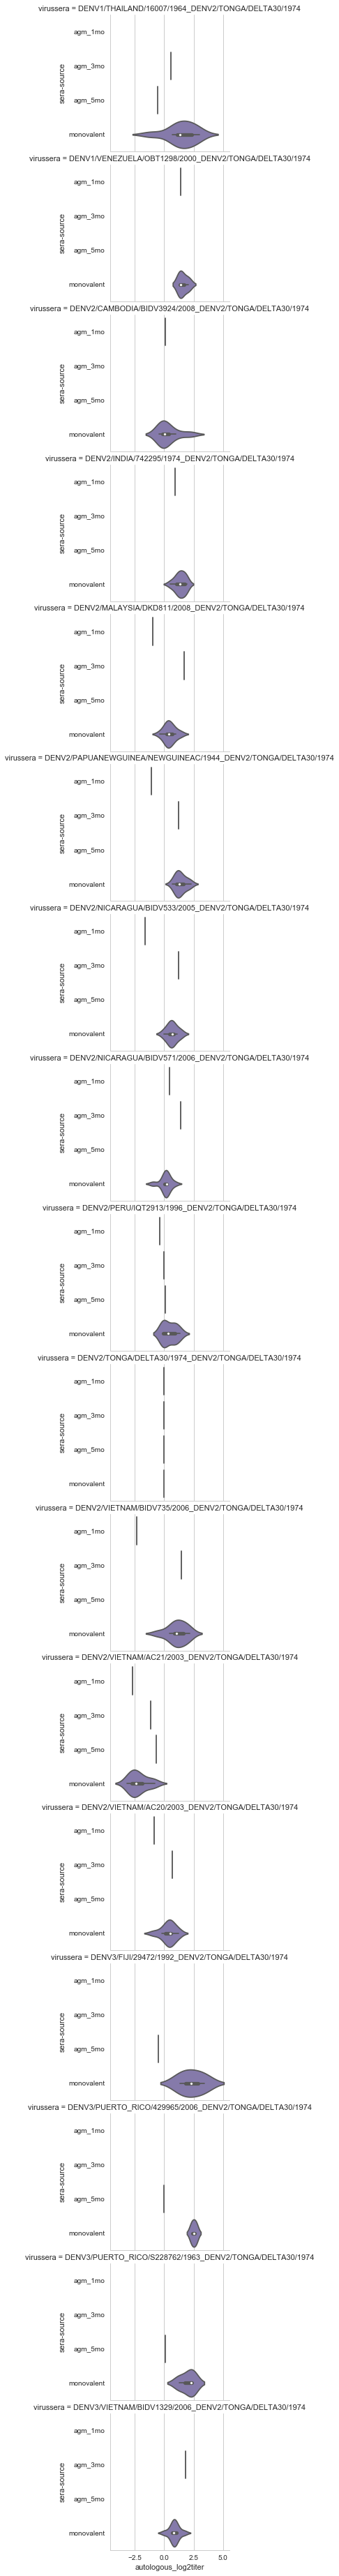

In [20]:
sns.set(rc={"font.size":8,"axes.titlesize":1})
sns.set_style('whitegrid')
plt.figure(figsize=(7.5, 20))

g = sns.FacetGrid(all_comparable_titers, row='virussera', hue='sera-source')  
g.map(sns.violinplot, 'autologous_log2titer', 'sera-source')
g.set(xlim=(-5, 5), xticks=(-5,-4,-3,-2,-1,0,1,2,3,4,5))

In [21]:
## Option 4: Aggregate measurements by species first, compare aggregated measurements directly 


##(don't do this. but, it's useful code to keep around.)

# aggregated_titers = titers.groupby(by=['virus', 'sera', 'species'])['autologous_log2titer'].aggregate(lambda x: (np.mean(x), np.std(x)))
# aggregated_titers.head()
# comparable_titers = [i for i in aggregated_titers.index.values if 
#                      (i[0], i[1], 'agm') in aggregated_titers.index and 
#                      (i[0], i[1], 'human') in aggregated_titers.index ]
# aggregated_comparable_titers = aggregated_titers.loc[comparable_titers] # Pull the values that are present in both human and agm datasets.
# aggregated_comparable_titers = aggregated_comparable_titers.unstack() # Unstack the last level of the series's multilevel index --> df with two columns, one for each species.

# aggregated_comparable_titers[['agm_mean', 'agm_stddev']] = aggregated_comparable_titers['agm'].apply(pd.Series) # Split mean and stddev values into two columns
# aggregated_comparable_titers[['human_mean', 'human_stddev']] = aggregated_comparable_titers['human'].apply(pd.Series)

In [22]:
# fig, ax = plt.subplots()
# ax.errorbar(x = list(aggregated_comparable_titers['human']), y = list(aggregated_comparable_titers['agm']), 
#             xerr = list(aggregated_comparable_titers['human_stddev']), yerr = list(aggregated_comparable_titers['agm_stddev']), 
#             fmt = 'o')
# ax.xlabel = 'Normalized AGM Titers, 1 Mo. Post Infection'
# ax.ylabel = 'Normalized Human Titers, 1.5 Mo. Post Infection'
# plt.show()